In [15]:
import pandas as pd
import sqlite3

# Connect (creates file if it doesn't exist)
conn = sqlite3.connect("nba_draft.db")
cursor = conn.cursor()

draft_df = pd.read_csv("nbaplayersdraft.csv")

team_df = pd.read_csv("Team_Records.csv")

#print(draft_df.head(10))

#print(team_df.head(10))

Here I loaded two datasets, one a comprehensive list of all NBA draft picks since 1989, as well as their player stats over the years since 1989 onwards. The second is a dataset of nba teams and their seasonal statistics since the start of the nba. I am attempting to answer a few questions, but mostly whether draft success correlates to overall team success, and if so what makes a successful draft? How do we measure that? But first cleaning data

In [16]:
print(draft_df.isnull().sum())
draft_df.columns = draft_df.columns.str.strip().str.lower().str.replace(" ", "_")
draft_df['overall_pick'] - draft_df["overall_pick"].astype(int)
draft_df["year"] = draft_df["year"].astype(int)

draft_df = draft_df.drop_duplicates()

#print(draft_df['team'].unique())

id                             0
year                           0
rank                           0
overall_pick                   0
team                           0
player                         0
college                      337
years_active                 253
games                        253
minutes_played               253
points                       253
total_rebounds               253
assists                      253
field_goal_percentage        257
3_point_percentage           377
free_throw_percentage        289
average_minutes_played       253
points_per_game              253
average_total_rebounds       253
average_assists              253
win_shares                   253
win_shares_per_48_minutes    254
box_plus_minus               254
value_over_replacement       253
dtype: int64


In [17]:
draft_df['college'] = draft_df['college'].fillna('Unknown')

#covering the numeric col null vals
numeric_cols = [
    'years_active','games','minutes_played','points','total_rebounds','assists',
    'field_goal_percentage','3_point_percentage','free_throw_percentage',
    'average_minutes_played','points_per_game','average_total_rebounds',
    'average_assists','win_shares','win_shares_per_48_minutes',
    'box_plus_minus','value_over_replacement'
]

for col in numeric_cols:
    draft_df[col] = pd.to_numeric(draft_df[col], errors='coerce')

In [18]:
#Loading our new data in sqlite3
draft_df.to_sql("draft", conn, if_exists="replace", index=False)


1922

The season data was very difficult to get prepared, trhe dash included in each cell was not the ascii dash but an en dash that couldnt be procedssed since it does not encode like the standard use dash

In [ ]:
import pandas as pd
import sqlite3

#clean the team data
team_df = pd.read_csv("Team_Records.csv")

# Clean Season column (fix en-dash issue)
team_df['Season'] = team_df['Season'].astype(str).str.strip()
team_df['season_clean'] = team_df['Season'].str.replace('–', '-', regex=False)
team_df['season_clean'] = team_df['season_clean'].str.replace(r'^[^\d]*', '', regex=True)
team_df['season_start'] = team_df['season_clean'].str.extract(r'(\d{4})')[0].astype(float)

# Keep seasons >= 1989
team_df_post1989 = team_df[team_df['season_start'] >= 1989].copy()

# Rename to SQL-friendly names
team_df_post1989 = team_df_post1989.rename(columns={
    "Season": "season_text",
    "Team": "team",
    "W": "wins",
    "L": "losses",
    "W/L%": "win_percentage"
})

conn = sqlite3.connect("nba_draft.db")
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS team_records;")

cursor.execute("""
CREATE TABLE team_records (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    season_start INTEGER,
    season_text TEXT,
    team TEXT,
    wins INTEGER,
    losses INTEGER,
    win_percentage REAL
);
""")
conn.commit()
# -----------------------------
team_df_post1989[['season_start','season_text','team','wins','losses','win_percentage']] \
    .to_sql("team_records", conn, if_exists="append", index=False)

query = "SELECT season_start, team, wins, losses, win_percentage FROM team_records LIMIT 10;"
print(pd.read_sql(query, conn))

conn.close()


   season_start             team  wins  losses  win_percentage
0          2017   Boston Celtics    29      10           0.744
1          2016  Boston Celtics*    53      29           0.646
2          2015  Boston Celtics*    48      34           0.585
3          2014  Boston Celtics*    40      42           0.488
4          2013   Boston Celtics    25      57           0.305
5          2012  Boston Celtics*    41      40           0.506
6          2011  Boston Celtics*    39      27           0.591
7          2010  Boston Celtics*    56      26           0.683
8          2009  Boston Celtics*    50      32           0.610
9          2008  Boston Celtics*    62      20           0.756


In [ ]:
import pandas as pd
import sqlite3
draft_df = pd.read_csv("nbaplayersdraft.csv")
draft_df.rename(columns={"3_point_percentage": "three_point_percentage"}, inplace=True)

conn = sqlite3.connect("nba_draft.db")
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS draft_info;")

cursor.execute("""
CREATE TABLE draft_info (
    id INTEGER PRIMARY KEY,
    year INTEGER,
    rank INTEGER,
    overall_pick INTEGER,
    team TEXT,
    player TEXT,
    college TEXT,
    years_active INTEGER,
    games INTEGER,
    minutes_played INTEGER,
    points INTEGER,
    total_rebounds INTEGER,
    assists INTEGER,
    field_goal_percentage REAL,
    three_point_percentage REAL,
    free_throw_percentage REAL,
    average_minutes_played REAL,
    points_per_game REAL,
    average_total_rebounds REAL,
    average_assists REAL,
    win_shares REAL,
    win_shares_per_48_minutes REAL,
    box_plus_minus REAL,
    value_over_replacement REAL
);
""")
conn.commit()

# -----------------------------
draft_df.to_sql("draft_info", conn, if_exists="append", index=False)
query = "SELECT player, team, year, overall_pick, points, assists FROM draft_info LIMIT 10;"
print(pd.read_sql(query, conn))

#conn.close()


            player team  year  overall_pick  points  assists
0   Pervis Ellison  SAC  1989             1    4494      691
1      Danny Ferry  LAC  1989             2    6439     1185
2     Sean Elliott  SAS  1989             3   10544     1897
3        Glen Rice  MIA  1989             4   18336     2097
4        J.R. Reid  CHH  1989             5    5680      639
5      Stacey King  CHI  1989             6    2819      387
6   George McCloud  IND  1989             7    6925     1769
7      Randy White  DAL  1989             8    2083      175
8     Tom Hammonds  WSB  1989             9    3617      378
9  Pooh Richardson  MIN  1989            10    7083     4180


Now, all that data is consolidated into this one database, which we have enabled to run sql on. The cleaning and assembly of these datasets was precarious, there were multiple issues with the original encoding of the data, since one was personally scraped by me and one was created by another person online. But regardlesss they are now ready to be queried.
One diffrenet aspect of this project is that this is utilizing SQLite withing python(sqlite3) so we need to write our queries a lot like the original project in Oracle Live SQL, but coated with another layer of python to actually use and view results.

In [ ]:
query = """
SELECT
    d.player,
    d.team,
    d.year,
    d.overall_pick,
    d.rank,
    d.points,
    d.assists,
    d.total_rebounds,
    d.win_shares,
    t.wins,
    t.losses,
    t.win_percentage
FROM draft_info d
JOIN team_records t
ON d.team = t.team
AND d.year = t.season_start
ORDER BY d.year, d.overall_pick
LIMIT 20;
"""
result_df = pd.read_sql(query, conn)
print(result_df)

Empty DataFrame
Columns: [player, team, year, overall_pick, rank, points, assists, total_rebounds, win_shares, wins, losses, win_percentage]
Index: []


This returned an empty dataframe since in one db, the teams are lsited as their abbreviaations, and the other features their full city+name, so we will remedy that here


In [ ]:
#Clean team names in team_records
team_df_post1989['team'] = team_df_post1989['team'].str.replace('*', '', regex=False).str.strip()

team_map = {
    "ATL": "Atlanta Hawks",
    "BOS": "Boston Celtics",
    "BRK": "Brooklyn Nets",
    "NJN": "New Jersey Nets",
    "CHA": "Charlotte Hornets",
    "CHI": "Chicago Bulls",
    "CLE": "Cleveland Cavaliers",
    "DAL": "Dallas Mavericks",
    "DEN": "Denver Nuggets",
    "DET": "Detroit Pistons",
    "GSW": "Golden State Warriors",
    "HOU": "Houston Rockets",
    "IND": "Indiana Pacers",
    "LAC": "Los Angeles Clippers",
    "LAL": "Los Angeles Lakers",
    "MEM": "Memphis Grizzlies",
    "MIA": "Miami Heat",
    "MIL": "Milwaukee Bucks",
    "MIN": "Minnesota Timberwolves",
    "NOP": "New Orleans Pelicans",
    "NOH": "New Orleans Hornets",
    "NYK": "New York Knicks",
    "OKC": "Oklahoma City Thunder",
    "SEA": "Seattle SuperSonics",
    "ORL": "Orlando Magic",
    "PHI": "Philadelphia 76ers",
    "PHX": "Phoenix Suns",
    "POR": "Portland Trail Blazers",
    "SAC": "Sacramento Kings",
    "SAS": "San Antonio Spurs",
    "TOR": "Toronto Raptors",
    "UTA": "Utah Jazz",
    "WAS": "Washington Wizards",
    "VAN": "Vancouver Grizzlies",
    "CHA": "Charlotte Bobcats",
}

# mapping to draft_df
draft_df['team_full'] = draft_df['team'].map(team_map)

# Load cleaned data back into SQL
draft_df.to_sql('draft_info', conn, if_exists='replace', index=False)
team_df_post1989.to_sql('team_records', conn, if_exists='replace', index=False)

query = """
SELECT d.player, d.team_full AS team, d.year, d.overall_pick,
      t.wins, t.losses, t.win_percentage
FROM draft_info d
JOIN team_records t
  ON d.team_full = t.team AND d.year = t.season_start
ORDER BY d.year, d.overall_pick
LIMIT 20;
"""
result_df = pd.read_sql(query, conn)
print(result_df)


             player                    team  year  overall_pick  wins  losses  \
0    Pervis Ellison        Sacramento Kings  1989             1    23      59   
1       Danny Ferry    Los Angeles Clippers  1989             2    30      52   
2      Sean Elliott       San Antonio Spurs  1989             3    56      26   
3         Glen Rice              Miami Heat  1989             4    18      64   
4       Stacey King           Chicago Bulls  1989             6    55      27   
5    George McCloud          Indiana Pacers  1989             7    42      40   
6       Randy White        Dallas Mavericks  1989             8    47      35   
7   Pooh Richardson  Minnesota Timberwolves  1989            10    22      60   
8     Nick Anderson           Orlando Magic  1989            11    18      64   
9   Mookie Blaylock         New Jersey Nets  1989            12    17      65   
10    Michael Smith          Boston Celtics  1989            13    52      30   
11     Tim Hardaway   Golden

In [ ]:

draft_df['team_full'] = draft_df['team_full'].str.strip().str.lower()
team_df_post1989['team'] = team_df_post1989['team'].str.strip().str.lower()

draft_df.to_sql('draft_info', conn, if_exists='replace', index=False)
team_df_post1989.to_sql('team_records', conn, if_exists='replace', index=False)

query = """
SELECT
    d.player,
    d.team_full AS draft_team,
    d.year,
    d.overall_pick,
    d.points,
    d.assists,
    d.total_rebounds,
    d.win_shares,
    t.team AS record_team,
    t.wins,
    t.losses,
    t.win_percentage
FROM draft_info d
JOIN team_records t
    ON d.team_full = t.team 
   AND d.year = t.season_start
ORDER BY d.year, d.overall_pick
LIMIT 20;
"""

result_df = pd.read_sql(query, conn)
print(result_df)


             player              draft_team  year  overall_pick   points  \
0    Pervis Ellison        sacramento kings  1989             1   4494.0   
1       Danny Ferry    los angeles clippers  1989             2   6439.0   
2      Sean Elliott       san antonio spurs  1989             3  10544.0   
3         Glen Rice              miami heat  1989             4  18336.0   
4       Stacey King           chicago bulls  1989             6   2819.0   
5    George McCloud          indiana pacers  1989             7   6925.0   
6       Randy White        dallas mavericks  1989             8   2083.0   
7   Pooh Richardson  minnesota timberwolves  1989            10   7083.0   
8     Nick Anderson           orlando magic  1989            11  11529.0   
9   Mookie Blaylock         new jersey nets  1989            12  11962.0   
10    Michael Smith          boston celtics  1989            13    698.0   
11     Tim Hardaway   golden state warriors  1989            14  15373.0   
12      Todd

In [ ]:
#Which teams drafter the most points since 1989
query= """
SELECT 
    d.team_full AS team,
    SUM(d.points) AS total_points_from_draft
FROM draft_info d
GROUP BY d.team_full
ORDER BY total_points_from_draft DESC
LIMIT 10;
"""
result_df = pd.read_sql(query, conn)
print(result_df)
#close out connection for neatness b4 next step
conn.close()

                     team  total_points_from_draft
0                    None                 437713.0
1   golden state warriors                 254531.0
2      philadelphia 76ers                 251631.0
3  minnesota timberwolves                 251416.0
4         milwaukee bucks                 250872.0
5     cleveland cavaliers                 241877.0
6          boston celtics                 239314.0
7        sacramento kings                 231768.0
8     seattle supersonics                 225495.0
9           chicago bulls                 222613.0


In [ ]:
#which draft classes were the best overall players
query= """SELECT 
    d.year,
    SUM(d.win_shares) AS draft_class_win_shares,
    SUM(d.points) AS draft_class_points
FROM draft_info d
GROUP BY d.year
ORDER BY draft_class_win_shares DESC
LIMIT 10;
"""
result_df = pd.read_sql(query, conn)
print(result_df)

   year  draft_class_win_shares  draft_class_points
0  1996                  1464.3            277202.0
1  2003                  1436.0            279974.0
2  1998                  1371.0            279300.0
3  2008                  1343.3            259845.0
4  2005                  1327.5            250846.0
5  1999                  1311.9            229258.0
6  2001                  1279.8            229939.0
7  2009                  1253.0            247846.0
8  1995                  1169.9            208918.0
9  1992                  1154.7            225630.0


Now that we have a working database w queries tested, we will now analyze the impact of draft classes on successful teams. What we want to see is the immediate impact of rookie picks and the relative impact over time(win shares above replacement compared to average pick at the draft slot)
To that end, we will aggregate the total win shares from each draft class per team, per year, and the top pick impact(1st rounders) normalized by the # of picks to eliminate bias towards teams with less picks
That will join with win percentage data from the team_records database
Along the way we'll use a mix of Seaborn and Matplotlib to illustrate each relationship and their significance throughout.
To quantify the impact of picks we will use Pearson Correlation between draft win shares and win percentage, maybe lin reg model dunno yet write later

In [43]:
#Building our aggregated dataset
import pandas as pd
import sqlite3
import numpy as np
#reopen connect
conn = sqlite3.connect("nba_draft.db")

#aggregate: sum of win_shares per team/year, basic num stuff, join team record for  season
agg_query = """
SELECT 
    d.team_full AS team,
    d.year AS year,
    SUM(COALESCE(d.win_shares, 0)) AS draft_win_shares,
    AVG(d.win_shares) AS avg_win_shares,
    COUNT(*) AS num_picks,
    AVG(d.overall_pick) AS avg_overall_pick,
    t.wins AS wins,
    t.win_percentage AS win_percentage,
    t.season_start AS season_start
FROM draft_info d
JOIN team_records t
  ON d.team_full = t.team
  AND d.year = t.season_start
GROUP BY d.team_full, d.year, t.wins, t.win_percentage, t.season_start
ORDER BY d.year, d.team_full;
"""
df = pd.read_sql(agg_query, conn)
df['avg_win_shares'] = pd.to_numeric(df['avg_win_shares'], errors='coerce').fillna(0)
df['draft_win_shares'] = pd.to_numeric(df['draft_win_shares'], errors='coerce')
df['avg_win_shares']   = pd.to_numeric(df['avg_win_shares'], errors='coerce')
df['num_picks']        = pd.to_numeric(df['num_picks'], errors='coerce')
df['avg_overall_pick'] = pd.to_numeric(df['avg_overall_pick'], errors='coerce')
df['wins']             = pd.to_numeric(df['wins'], errors='coerce')
df['win_percentage']   = pd.to_numeric(df['win_percentage'], errors='coerce')

#quick head
#print(df.head())
df.to_sql('team_draft_agg', conn, if_exists='replace', index=False)

#print(df[['draft_win_shares', 'wins', 'win_percentage', 'num_picks']].describe())
print('Missing vals:\n', df.isnull().sum())

Missing vals:
 team                0
year                0
draft_win_shares    0
avg_win_shares      0
num_picks           0
avg_overall_pick    0
wins                0
win_percentage      0
season_start        0
dtype: int64


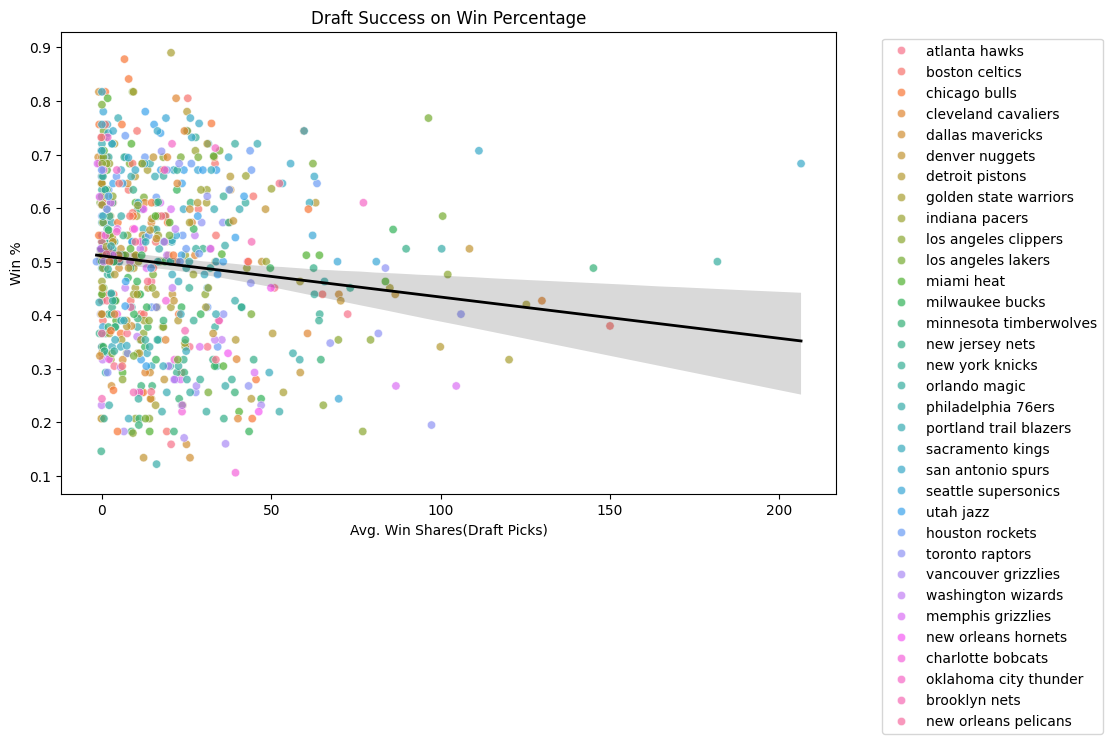

In [47]:

import matplotlib.pyplot as plt
import seaborn as sns
#Q: Do successful drafts contribute to winning seasons?
#Scatterplot: X=avg win shares, y= win percentage

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="avg_win_shares",
    y="win_percentage",
    hue="team",
    alpha=0.7
)

sns.regplot(
    data=df,
    x="avg_win_shares",
    y="win_percentage",
    scatter= False,
    color= "black",
    line_kws={"linewidth":2}
)

plt.title("Draft Success on Win Percentage")
plt.xlabel("Avg. Win Shares(Draft Picks)")
plt.ylabel("Win %")
plt.legend(bbox_to_anchor= (1.05, 1), loc = 'upper left')
plt.show()

This is clearly too messy to be useful. Continuing in the analysis, I will begin working on the correlation matrix between multiple stats within the joint dataframe.

                      wins  win_percentage
draft_win_shares -0.190401       -0.208895
avg_win_shares   -0.100382       -0.120771
num_picks        -0.186390       -0.183374
avg_overall_pick  0.298757        0.321410
wins              1.000000        0.921563
win_percentage    0.921563        1.000000


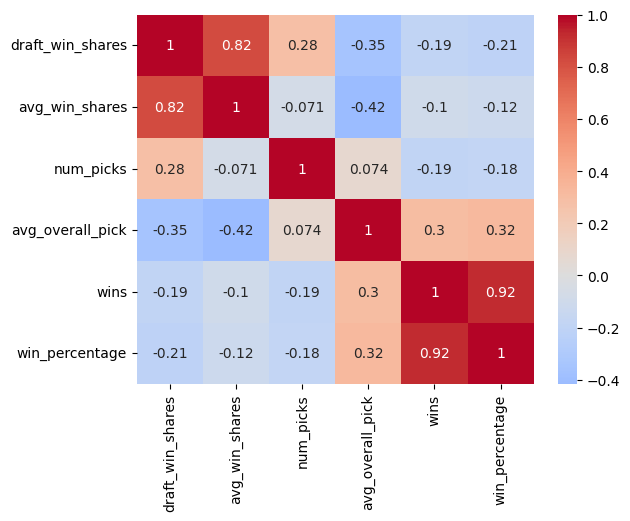

In [ ]:
corr_matrix = df[['draft_win_shares', 'avg_win_shares', 'num_picks', 'avg_overall_pick', 'wins','win_percentage']].corr()
print(corr_matrix[['wins','win_percentage']])

#Now that we have a corr matrix, we can print out our heatmap
sns.heatmap(corr_matrix, annot=True, cmap = 'coolwarm', center=0)
plt.show()

This heatmap does not currently support the thesis that draft success directly contributes to team success, but there is a reason for that. Rookie year draft picks definitely do not make much impact on their first year, they need dev time. next I am going to analyze lagged regression, are they more directly correlated if we use the next few years instead of the first.

In [ ]:
#import numpy as np
#Sorting so the time shift works
#df = df.sort_values(by=['team', 'year'])
#df['future_win_percentage'] = df.groupby('team')['win_percentage'].shift(-1)
#this was hell on the data so dropping missing vals for the 8th time
#lagdf = df.dropna(subset=['future_win_percentage'])


#x = lagdf[['draft_win_shares','avg_win_shares','avg_overall_pick']].values
##y = lagdf[['future_win_percentage']].values

#x = np.column_stack([np.ones(x.shape[0]), x])

In [ ]:
#running with numpy's least squares alg, math from ty's git(thank you ty)
#beta, residuals, rank, s = np.linalg.lstsq(x,y, rcond= None)
#print("intercepy and coeff", beta)

#y_pred = x @ beta
#ss_res = np.sum((y - y_pred) ** 2)
#ss_tot = np.sum((y - np.mean(y)) ** 2)
#getting our r^2 to use in our analysis
#r2 = 1 - (ss_res / ss_tot)
#print("R²:", r2)

R²: 0.05625199232544398



Summary:
   lag  n_obs        r2  intercept  draft_win_shares  avg_win_shares  \
0    1    702  0.056252   0.398655         -0.000563        0.001178   
1    2    669  0.022640   0.424321          0.000015        0.000413   
2    3    636  0.024814   0.418693          0.000137        0.000633   
3    4    604  0.016352   0.455800          0.000020        0.000814   
4    5    573  0.022603   0.459500         -0.000301        0.001299   
5    6    542  0.008117   0.487406          0.000062        0.000445   
6    7    512  0.002383   0.480334          0.000100        0.000159   
7    8    483  0.006549   0.460948          0.000151        0.000121   

   avg_overall_pick  
0          0.003190  
1          0.002190  
2          0.002065  
3          0.000845  
4          0.000759  
5          0.000011  
6          0.000434  
7          0.001076  


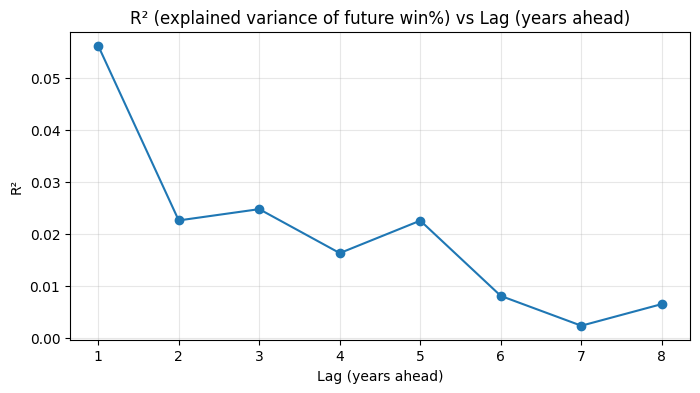

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#This portion has been messy, so going to make a copy to keep the analysis clean and the og df seperated.
work = df.copy()

def find_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    #case insensitive fallback
    for col in cols:
        lc = col.lower()
        for cand in candidates:
            if cand in lc:
                return col
    return None

team_col = find_col(['team','team_full','team_name','franchise'], work.columns)
year_col = find_col(['year','season_start','season','draft_year'], work.columns)
win_col  = find_col(['win_percentage','win_pct','winrate','win_rate','win%','wins'], work.columns)

if team_col is None or year_col is None or win_col is None:
    missing = [name for name, col in [('team',team_col),('year',year_col),('win%',win_col)] if col is None]
    raise KeyError(f"Couldn't auto-detect columns for: {missing}. Available cols: {list(work.columns)}")

# cleaning basic format
work[team_col] = work[team_col].astype(str).str.strip()
work[year_col] = pd.to_numeric(work[year_col], errors='coerce')

work = work.sort_values(by=[team_col, year_col]).reset_index(drop=True)

max_lag = 8
for lag in range(1, max_lag + 1):
    work[f'future_win_percentage_{lag}'] = work.groupby(team_col)[win_col].shift(-lag)

requested_predictors = ['draft_win_shares', 'avg_win_shares', 'avg_overall_pick']
predictors = [p for p in requested_predictors if p in work.columns]
if not predictors:
    raise KeyError(f"None of the requested draft predictors found. Expected any of: {requested_predictors}. Available cols: {list(work.columns)}")

results = []
for lag in range(1, max_lag+1):
    target = f'future_win_percentage_{lag}'
    lagdf = work.dropna(subset=[target] + predictors)
    n_obs = lagdf.shape[0]

    # need at least (#predictors + 1) rows to estimate intercept + coefficients
    if n_obs < (len(predictors) + 1):
        print(f"Skipping lag {lag}: insufficient observations ({n_obs}) for {len(predictors)} predictors.")
        results.append({'lag': lag, 'n_obs': n_obs, 'r2': np.nan, 'beta': None})
        continue

    X = lagdf[predictors].values
    X = np.column_stack([np.ones(X.shape[0]), X])
    y = lagdf[target].values

    #numpy lsq library for analysis math
    beta, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)

    # R^2 calc
    y_pred = X @ beta
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    results.append({'lag': lag, 'n_obs': n_obs, 'r2': r2, 'beta': beta})

#making a summary
rows = []
for r in results:
    row = {'lag': r['lag'], 'n_obs': r['n_obs'], 'r2': r['r2']}
    if isinstance(r['beta'], (list, np.ndarray)):
        row['intercept'] = r['beta'][0]
        for i, p in enumerate(predictors):
            row[p] = r['beta'][i+1]
    else:
        row['intercept'] = np.nan
        for p in predictors:
            row[p] = np.nan
    rows.append(row)

summary = pd.DataFrame(rows).sort_values('lag').reset_index(drop=True)
print("\nSummary:")
print(summary)

# ---- Plot R² vs lag ----
plt.figure(figsize=(8,4))
plt.plot(summary['lag'], summary['r2'], marker='o')
plt.title('R² (explained variance of future win%) vs Lag (years ahead)')
plt.xlabel('Lag (years ahead)')
plt.ylabel('R²')
plt.xticks(range(1, max_lag+1))
plt.grid(alpha=0.3)
plt.show()


The lagged regression shows an interesting relationship. Draft Success is more meaningful in the early years, 1-2, and falls off over the course of multiple years. This makes some sense, trades are common in the nba and alter team comp every year. The most conclusive read is that more than a successful draft, retaining top talent and making intelligent trades are more immpactful for the long term success of a team.
My conclusion, While draft picks do have a meaningful impact on a team's win percentage in the short term, it has little effect on longterm team building. A more effect use of time is to focus on retaining your best picks and trading out your least compatible players quickly.